# Stat 303-2 Project
## Linear Regression

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('auto-mpg.csv')

# Renaming model year and car name column
data = data.rename(columns={'model year': 'model_year'})
data = data.rename(columns={'car name': 'car_name'})

# Binning cylinder column
bins = [3,4,5,6,8]
data['cyl_binned'] = pd.cut(data['cylinders'],bins = bins)

# Replace '?' with 'na'
data = data.replace('?', np.nan)

# Convert columns from object to float datatype
data['horsepower'] = data['horsepower'].astype(float)

# Mapping origin column to countries from key
data['origin'] = data['origin'].map({1: 'US', 2: 'Europe', 3: 'Asia'})

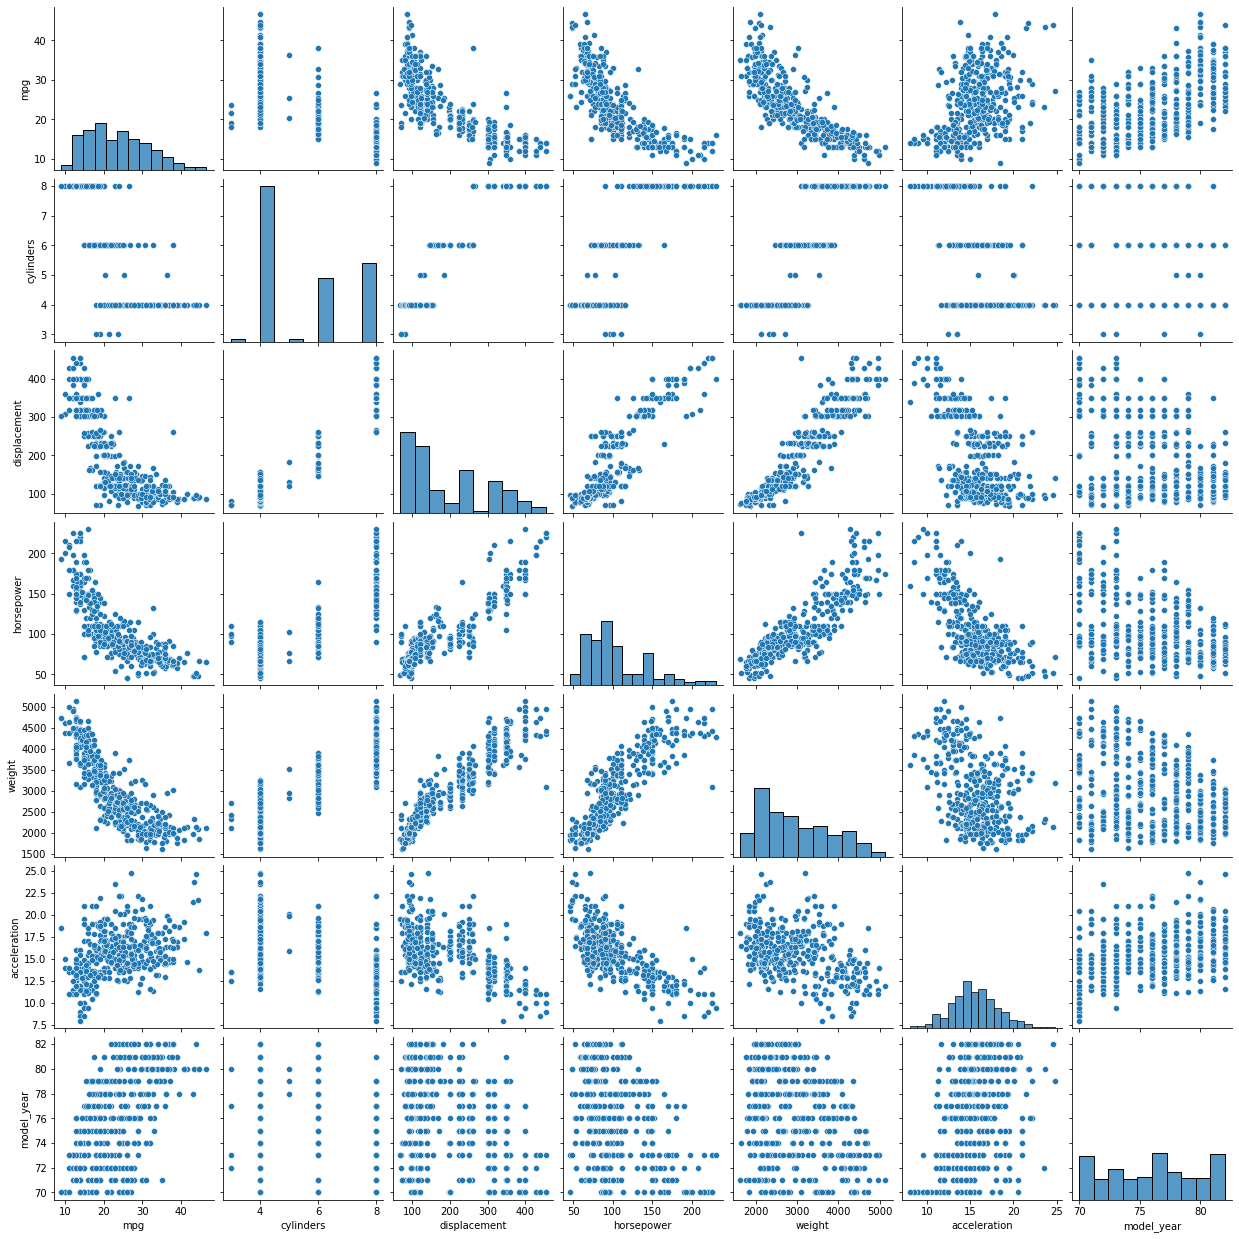

In [3]:
sns.pairplot(data)

In [4]:
data.corrwith(data.mpg)

mpg             1.000000
cylinders      -0.775396
displacement   -0.804203
horsepower     -0.778427
weight         -0.831741
acceleration    0.420289
model_year      0.579267
dtype: float64

In [5]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,cyl_binned
0,18.0,8,307.0,130.0,3504,12.0,70,US,chevrolet chevelle malibu,"(6, 8]"
1,15.0,8,350.0,165.0,3693,11.5,70,US,buick skylark 320,"(6, 8]"
2,18.0,8,318.0,150.0,3436,11.0,70,US,plymouth satellite,"(6, 8]"
3,16.0,8,304.0,150.0,3433,12.0,70,US,amc rebel sst,"(6, 8]"
4,17.0,8,302.0,140.0,3449,10.5,70,US,ford torino,"(6, 8]"


In [6]:
# model_year value count

data.model_year.value_counts()

73    40
78    36
76    34
82    31
75    30
70    29
79    29
80    29
81    29
71    28
72    28
77    28
74    27
Name: model_year, dtype: int64

In [7]:
# car_name value count

data.car_name.value_counts()

ford pinto             6
toyota corolla         5
amc matador            5
ford maverick          5
chevrolet chevette     4
                      ..
chevrolet monza 2+2    1
ford mustang ii        1
pontiac astro          1
amc pacer              1
chevy s-10             1
Name: car_name, Length: 305, dtype: int64

<AxesSubplot:>

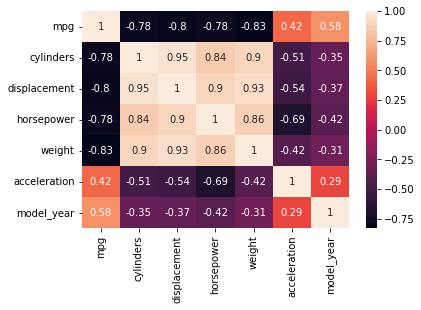

In [8]:
corr = data.corr()
sns.heatmap(corr, annot = True)

In [9]:
categ = list(data.select_dtypes(include=['object']).columns)
nums = list(data.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {categ}')
print(f'numerical variables:  {nums}')

categorical variables:  ['origin', 'car_name']
numerical variables:  ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'cyl_binned']


<AxesSubplot:xlabel='cylinders', ylabel='mpg'>

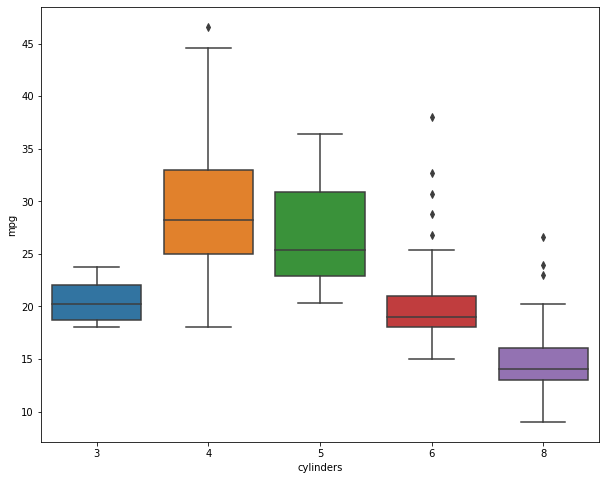

In [10]:
# Cylinder to mpg to see relationship and distribution
plt.figure(figsize=(10,8))
sns.boxplot(x='cylinders',y='mpg',data=data)

<AxesSubplot:xlabel='mpg', ylabel='weight'>

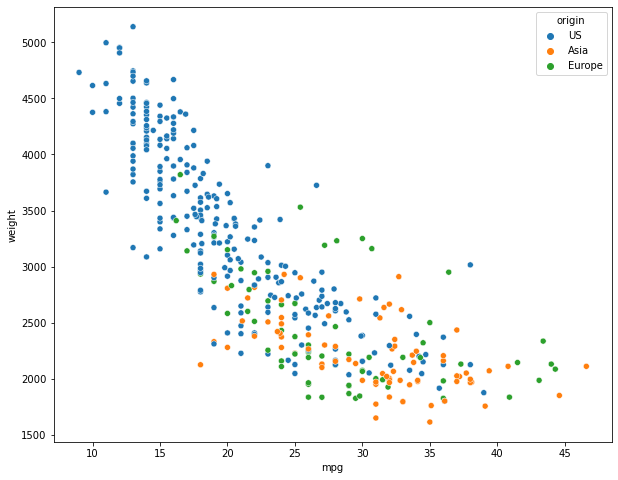

In [11]:
# Weight to mpg with country as category
plt.figure(figsize=(10,8))
sns.scatterplot(x='mpg',y='weight',hue='origin',data=data)

<AxesSubplot:xlabel='origin', ylabel='mpg'>

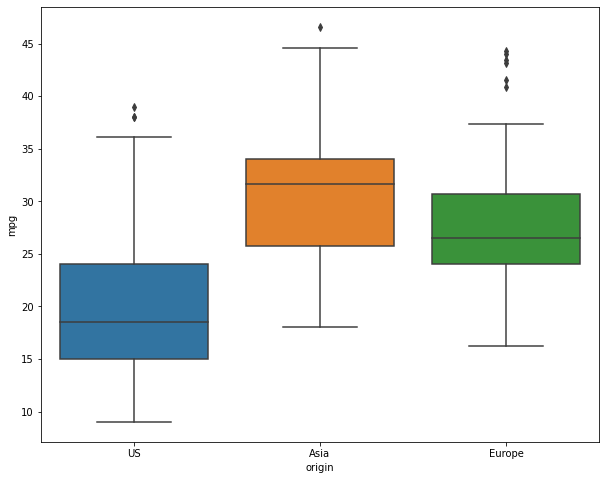

In [12]:
# Country to mpg to see relationship and distribution
plt.figure(figsize=(10,8))
sns.boxplot(x='origin',y='mpg',data=data)

In [13]:
# Split the data into training and test
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8)) # 80% of data in training set
test = data.drop(train.index)

In [14]:
# VIF to detect multicollinearity
X = train[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']]

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Check for missing values and convert data to numeric type
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
X = X.dropna()

X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

        feature         VIF
0         const  778.714466
1     cylinders   10.291058
2  displacement   18.886514
3    horsepower    9.285542
4        weight   10.587000
5  acceleration    2.549150
6    model_year    1.268785


## Non-transformed model

In [15]:
model = smf.ols(formula = 'mpg ~ cyl_binned + horsepower + weight + acceleration + model_year', data = train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     220.0
Date:                Sun, 05 Mar 2023   Prob (F-statistic):          3.74e-114
Time:                        23:18:15   Log-Likelihood:                -790.65
No. Observations:                 308   AIC:                             1597.
Df Residuals:                     300   BIC:                             1627.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      -10.1165      5.082     -1.991      0.047     -20.117      -0.116
cyl_binned[T.Interval(4, 5, closed='right')]     1.4538      1.913      0.760      0.448      -2.311       5.218
cyl_binned[T.Interval(5, 6, closed='right')]    -3.0371      0.644     -4.718      0.000      -4.304      -1.770
cyl_binned[T.Interval(6, 8, closed='right')]    -0.1987      1.084     -0.183      0.855      -2.333       1.935
horsepower                                      -0.0242      0.015     -1.641      0.102      -0.053       0.005
weight                                          -0.0055      0.001     -8.717      0.000      -0.007      -0.004
acceleration                                    -0.0874      0.109     -0.800      0.425      -0.303       0.128
model_year                                       0.7198      0.056     12.844      0.000       0.609       0.830
==============================================================================
Omnibus:                       47.049   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.178
Skew:                           0.765   Prob(JB):                     1.45e-23
Kurtosis:                       5.420   Cond. No.                     8.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model with quadratic term for `weight`

In [16]:
model = smf.ols(formula = 'mpg ~ cyl_binned + horsepower + weight + I(weight**2) + acceleration + model_year', data = train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     237.3
Date:                Sun, 05 Mar 2023   Prob (F-statistic):          1.16e-124
Time:                        23:18:15   Log-Likelihood:                -762.81
No. Observations:                 308   AIC:                             1544.
Df Residuals:                     299   BIC:                             1577.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        6.6001      5.133      1.286      0.199      -3.500      16.701
cyl_binned[T.Interval(4, 5, closed='right')]     3.3077      1.767      1.872      0.062      -0.170       6.785
cyl_binned[T.Interval(5, 6, closed='right')]    -1.0815      0.641     -1.686      0.093      -2.344       0.181
cyl_binned[T.Interval(6, 8, closed='right')]    -0.1170      0.992     -0.118      0.906      -2.070       1.836
horsepower                                      -0.0219      0.014     -1.617      0.107      -0.048       0.005
weight                                          -0.0197      0.002    -10.219      0.000      -0.023      -0.016
I(weight ** 2)                                2.171e-06   2.82e-07      7.698      0.000    1.62e-06    2.73e-06
acceleration                                    -0.0915      0.100     -0.915      0.361      -0.288       0.105
model_year                                       0.7704      0.052     14.901      0.000       0.669       0.872
==============================================================================
Omnibus:                       58.498   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              150.434
Skew:                           0.888   Prob(JB):                     2.16e-33
Kurtosis:                       5.927   Cond. No.                     3.44e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
#Computing the RMSE of the model with the interaction terms
pred_mpg1 = model.predict(test)
np.sqrt(((test.mpg - pred_mpg1)**2).mean())

3.0461314728803903

## Model with quadratic terms for `horsepower` and `weight`

In [18]:
model1 = smf.ols(formula = 'mpg ~ horsepower + I(horsepower**2) + weight + I(weight**2) + acceleration + model_year', data = train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     312.7
Date:                Sun, 05 Mar 2023   Prob (F-statistic):          4.53e-127
Time:                        23:18:15   Log-Likelihood:                -775.43
No. Observations:                 312   AIC:                             1565.
Df Residuals:                     305   BIC:                             1591.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.6930      5.101      1.900      0.058      -0.345      19.731
horsepower            -0.1949      0.043     -4.558      0.000      -0.279      -0.111
I(horsepower ** 2)     0.0006      0.000      4.386      0.000       0.000       0.001
weight                -0.0156      0.002     -7.504      0.000      -0.020      -0.011
I(weight ** 2)      1.691e-06   2.98e-07      5.678      0.000     1.1e-06    2.28e-06
acceleration          -0.2205      0.107     -2.057      0.041      -0.431      -0.010
model_year             0.7938      0.051     15.528      0.000       0.693       0.894
==============================================================================
Omnibus:                       42.772   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.292
Skew:                           0.711   Prob(JB):                     2.47e-20
Kurtosis:                       5.218   Cond. No.                     3.41e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
#Computing the RMSE of the model with the interaction terms
pred_mpg = model1.predict(test)
np.sqrt(((test.mpg - pred_mpg)**2).mean())

2.9521676150436997

Text(0, 0.5, 'Residuals')

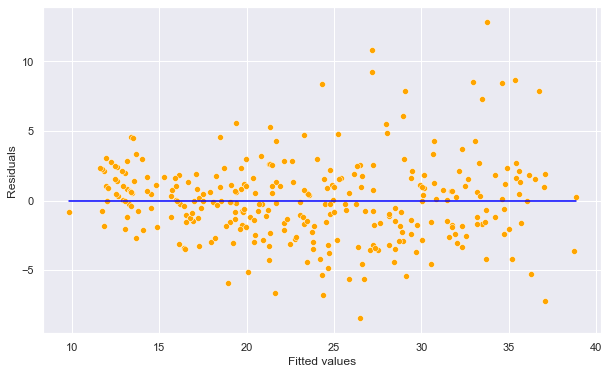

In [20]:
#Plotting residuals vs fitted values
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x = (model1.fittedvalues), y=(model1.resid),color = 'orange')
sns.lineplot(x = [model1.fittedvalues.min(),model1.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Studentized Residuals')

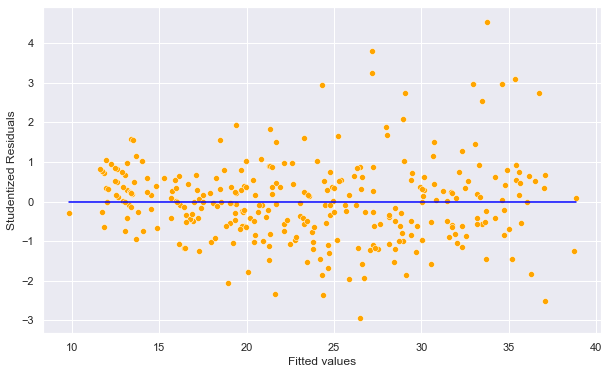

In [21]:
#Studentized residuals
out = model1.outlier_test()

#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model1.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model1.fittedvalues.min(),model1.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

In [22]:
#Number of points with absolute studentized residuals greater than 3
np.sum((np.abs(out.student_resid)>3))

4

## Model with `mpg` logged and above quadratic transformations

In [23]:
model2 = smf.ols(formula = 'np.log(mpg) ~ horsepower + I(horsepower**2) + weight + I(weight**2) + acceleration + model_year', data = train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     401.4
Date:                Sun, 05 Mar 2023   Prob (F-statistic):          1.66e-141
Time:                        23:18:17   Log-Likelihood:                 237.49
No. Observations:                 312   AIC:                            -461.0
Df Residuals:                     305   BIC:                            -434.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.3684      0.198     11.932      0.000       1.978       2.759
horsepower            -0.0062      0.002     -3.726      0.000      -0.009      -0.003
I(horsepower ** 2)  1.597e-05   5.26e-06      3.037      0.003    5.62e-06    2.63e-05
weight                -0.0005   8.07e-05     -5.645      0.000      -0.001      -0.000
I(weight ** 2)      3.606e-08   1.16e-08      3.112      0.002    1.33e-08    5.89e-08
acceleration          -0.0098      0.004     -2.358      0.019      -0.018      -0.002
model_year             0.0308      0.002     15.500      0.000       0.027       0.035
==============================================================================
Omnibus:                        7.576   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.597
Skew:                          -0.007   Prob(JB):                      0.00184
Kurtosis:                       3.984   Cond. No.                     3.41e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#Computing the RMSE of the model with the interaction terms
pred_mpg2 = np.exp(model2.predict(test))
np.sqrt(((test.mpg - pred_mpg2)**2).mean())

3.003820116515934

Text(0, 0.5, 'Residuals')

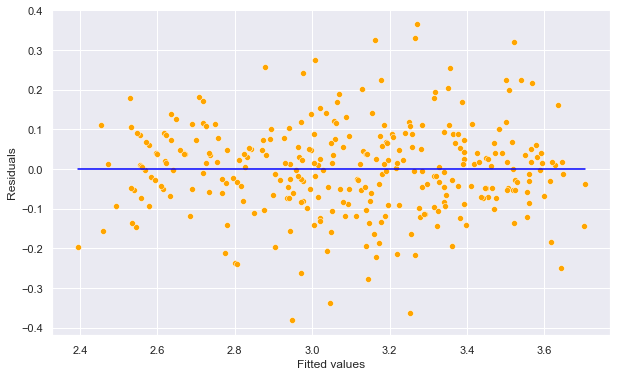

In [25]:
#Plotting residuals vs fitted values
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(x = (model2.fittedvalues), y=(model2.resid),color = 'orange')
sns.lineplot(x = [model2.fittedvalues.min(),model2.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

Text(0, 0.5, 'Studentized Residuals')

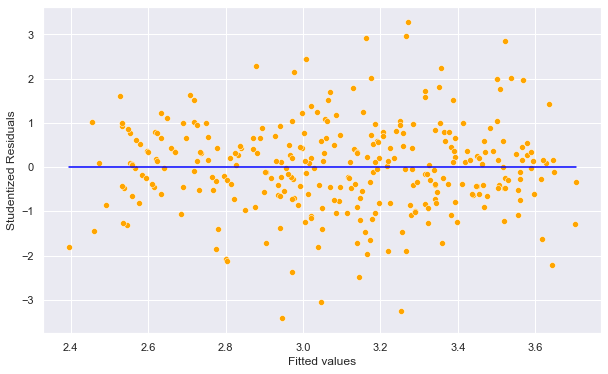

In [26]:
#Studentized residuals
out = model2.outlier_test()

#Plotting studentized residuals vs fitted values
sns.scatterplot(x = (model2.fittedvalues), y=(out.student_resid),color = 'orange')
sns.lineplot(x = [model2.fittedvalues.min(),model2.fittedvalues.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Studentized Residuals')

In [27]:
#Number of points with absolute studentized residuals greater than 3
np.sum((np.abs(out.student_resid)>3))

4

## Creating Dummy Variables

In [28]:
# Creating dummy variable for origin in train and test
dummy_origin = pd.get_dummies(train['origin'])
train = pd.concat([train,dummy_origin], axis = 1)

dummy_origin = pd.get_dummies(test['origin'])
test = pd.concat([test,dummy_origin], axis = 1)

## Ridge Regression

In [29]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,cyl_binned
0,18.0,8,307.0,130.0,3504,12.0,70,US,chevrolet chevelle malibu,"(6, 8]"
1,15.0,8,350.0,165.0,3693,11.5,70,US,buick skylark 320,"(6, 8]"
2,18.0,8,318.0,150.0,3436,11.0,70,US,plymouth satellite,"(6, 8]"
3,16.0,8,304.0,150.0,3433,12.0,70,US,amc rebel sst,"(6, 8]"
4,17.0,8,302.0,140.0,3449,10.5,70,US,ford torino,"(6, 8]"


In [30]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
cyl_binned      4
dtype: int64

In [31]:
# Copying dfs to drop na values
train2 = train.copy()
test2 = test.copy()

train2 = train2.dropna()
test2 = test2.dropna()

Text(0, 0.5, 'Frequency')

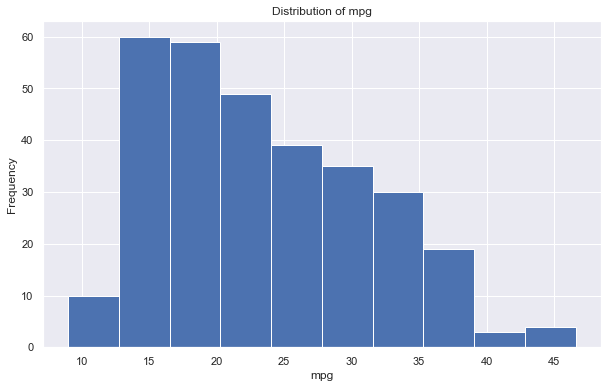

In [32]:
# Create histogram of mpg column
plt.hist(train2['mpg'])

# Add title and labels to the plot
plt.title('Distribution of mpg')
plt.xlabel('mpg')
plt.ylabel('Frequency')

In [33]:
#Taking the log transform of mpg as house prices have a right-skewed distribution
y = np.log(train2.mpg)

In [34]:
#Standardizing predictors so that each of them have zero mean and unit variance

#Filtering all predictors
excluded_cols = ["car_name","origin","cyl_binned","mpg"]

selected_cols = [col for col in train2.columns if col not in excluded_cols]
X = train2[selected_cols] 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data2 based on the same mean and variance as obtained on train2 data2
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train2 data2)
Xstd = scaler.transform(X)

In [35]:
#The tuning parameter lambda is referred as alpha in sklearn

#Creating a range of values of the tuning parameter to visualize the ridge regression coefficients
#for different values of the tuning parameter
alphas = 10**np.linspace(2,0.5,200)*0.5

In [36]:
#Finding the ridge regression coefficients for increasing values of the tuning parameter
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)

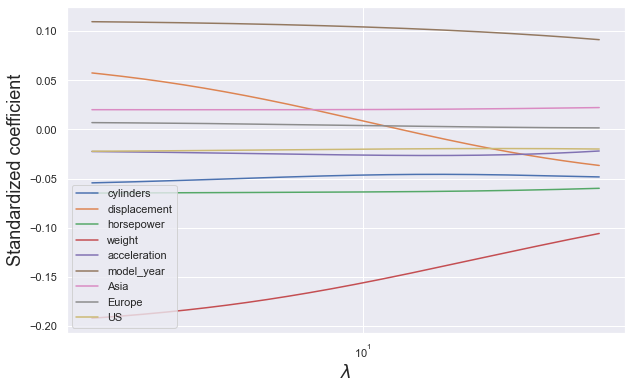

In [37]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train2[selected_cols]);

In [38]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

1.63698756806911

Text(0, 0.5, 'Cross-validation error')

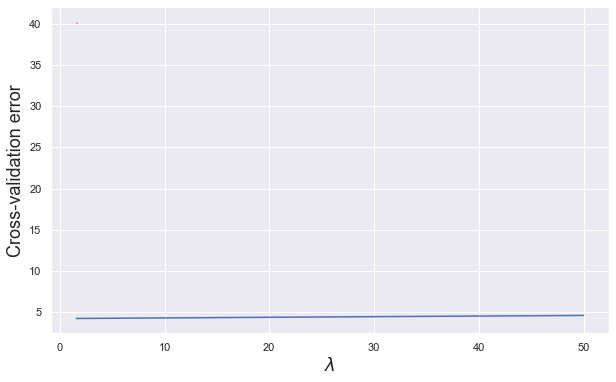

In [39]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[40,40.2],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

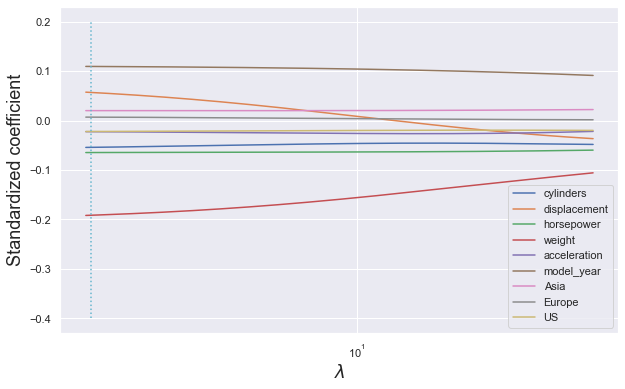

In [40]:
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[-0.4,0.2],':')
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train2[selected_cols]);

In [41]:
# RMSE
#Test dataset
Xtest = test2[selected_cols]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

In [42]:
#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

In [43]:
#RMSE on test data
np.sqrt(((np.exp(pred)-test2.mpg)**2).mean())

3.189244258424878

In [44]:
#Checking the coefficients of the ridge regression model
ridge.coef_

array([-0.05425085,  0.05686287, -0.0647607 , -0.19165042, -0.0225743 ,
        0.10947286,  0.02003521,  0.00686296, -0.02219405])

In [45]:
#R-squared on train data for the ridge regression model
r2_score(ridge.predict(Xstd),y)

0.8731478275265212

In [46]:
#R-squared on test data for the ridge regression model
r2_score(pred,np.log(test2.mpg))

0.8414959499573057

In [47]:
# get the coefficients
ridge_coefs = pd.DataFrame({'Predictors': X.columns, 'Coefficients': ridge.coef_})

# print the optimal value of the tuning parameter - lambda
print("Optimal alpha (lambda) value for ridge:", ridgecv.alpha_)

# print the coefficients
print("Coefficients:")
print(ridge_coefs)

# print the RMSE on test data
print("RMSE on test data:", np.sqrt(((np.exp(pred)-test2.mpg)**2).mean()))

# print the R-squared values
print("R-squared on train data:", r2_score(ridge.predict(Xstd),y))
print("R-squared on test data:", r2_score(pred,np.log(test2.mpg)))


Optimal alpha (lambda) value for ridge: 1.63698756806911
Coefficients:
     Predictors  Coefficients
0     cylinders     -0.054251
1  displacement      0.056863
2    horsepower     -0.064761
3        weight     -0.191650
4  acceleration     -0.022574
5    model_year      0.109473
6          Asia      0.020035
7        Europe      0.006863
8            US     -0.022194
RMSE on test data: 3.189244258424878
R-squared on train data: 0.8731478275265212
R-squared on test data: 0.8414959499573057


Text(0.5, 1.0, 'Residual Plot for Ridge Regression')

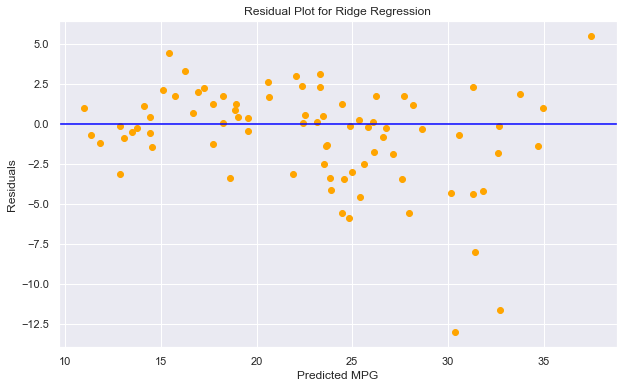

In [48]:
# Residual plot

residuals = np.exp(pred) - test2.mpg
plt.scatter(np.exp(pred), residuals, color = 'orange')
plt.axhline(y=0, color='blue')
plt.xlabel('Predicted MPG')
plt.ylabel('Residuals')
plt.title('Residual Plot for Ridge Regression')


## Lasso

In [49]:
#Finding the lasso coefficients for increasing values of the tuning parameter
alphas = 10**np.linspace(0,-2.5,200)*0.5
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

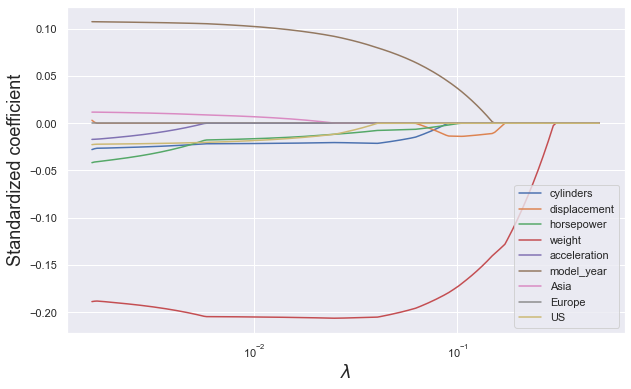

In [50]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train2[selected_cols]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train2[selected_cols]);

In [51]:
#Let us use cross validation to find the optimal value of the tuning parameter - lambda
#For the optimal lambda, the cross validation error will be the least

#Note that we are reducing the range of alpha so as to better visualize the minimum

lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.008968893117674464

Text(0, 0.5, 'Cross-validation error')

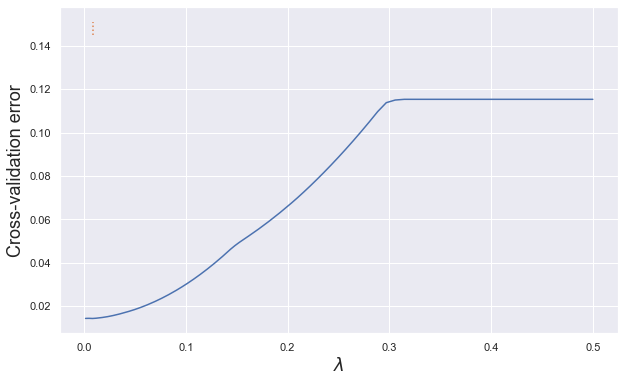

In [52]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

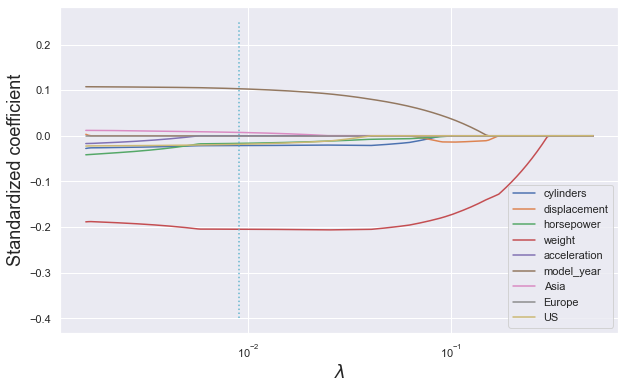

In [53]:
#Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda

plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train2[selected_cols]);
plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train2[selected_cols]);

In [54]:
#Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

In [55]:
#RMSE on test data
np.sqrt(((np.exp(pred)-test2.mpg)**2).mean())

3.091028790121332

In [56]:
#Checking the coefficients of the lasso model
lasso.coef_

array([-0.02153455, -0.        , -0.01672057, -0.20491891, -0.        ,
        0.10305813,  0.00731938,  0.        , -0.0188009 ])

In [57]:
#R-squared on train data for the lasso model
r2_score(lasso.predict(Xstd),y)

0.857891523445503

In [58]:
#R-squared on test data for the lasso model
r2_score(pred,np.log(test2.mpg))

0.8329419822280133

In [59]:
from sklearn.metrics import r2_score
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)

# Get the coefficients of the lasso model
lasso_coefs = lasso.coef_

# Get the names of the predictors
predictors = X.columns

# Remove any predictors that have a coefficient of zero
predictors = predictors[lasso_coefs != 0]

# Remove the corresponding coefficients
lasso_coefs = lasso_coefs[lasso_coefs != 0]
# Calculate R-squared for train and test sets
train_r2 = r2_score(y, lasso.predict(Xstd))
test_r2 = r2_score(test2.mpg, np.exp(pred))

# print the optimal value of the tuning parameter - lambda
print("Optimal alpha (lambda) value for lasso:", lassocv.alpha_)

# Create summary dataframe
lasso_summary = pd.DataFrame({'Predictors': predictors, 'Coefficients': lasso_coefs})

print(lasso_summary)

# print the RMSE on test data
print("RMSE on test data:", np.sqrt(((np.exp(pred)-test2.mpg)**2).mean()))

# print the R-squared values
print("R-squared on train data:", r2_score(lasso.predict(Xstd),y))
print("R-squared on test data:", r2_score(pred,np.log(test2.mpg)))


Optimal alpha (lambda) value for lasso: 0.008968893117674464
   Predictors  Coefficients
0   cylinders     -0.021535
1  horsepower     -0.016721
2      weight     -0.204919
3  model_year      0.103058
4        Asia      0.007319
5          US     -0.018801
RMSE on test data: 3.091028790121332
R-squared on train data: 0.857891523445503
R-squared on test data: 0.8329419822280133


Text(0.5, 1.0, 'Residual Plot for Lasso Regression')

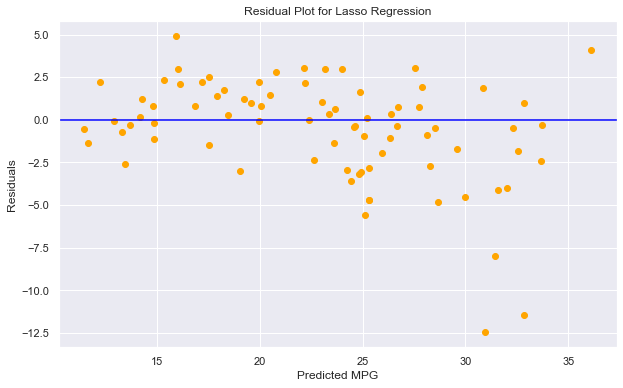

In [60]:
# Residual plot

residuals = np.exp(pred) - test2.mpg
plt.scatter(np.exp(pred), residuals, color = 'orange')
plt.axhline(y=0, color='blue')
plt.xlabel('Predicted MPG')
plt.ylabel('Residuals')
plt.title('Residual Plot for Lasso Regression')